### 데이터셋 정의하기
객체 검출, 인스턴스 분할 및 사용자 키포인트(Keypoint) 검출을 학습하기 위한 참조 스크립트를 통해 새로운 사용자 정의 데이터셋 추가를 쉽게 진행해 볼 수 있습니다. 데이터셋은 표준 torch.utils.data.Dataset 클래스를 상속 받아야 하며, __len__ 와 __getitem__ 메소드를 구현해 주어야 합니다.

데이터셋에서 필요한 유일한 특성은 __getitem__ 메소드가 다음을 반환 해야 하는 것입니다:

* 이미지 : PIL(Python Image Library) 이미지의 크기 (H, W)

* 대상: 다음의 필드를 포함하는 사전 타입

* boxes (FloatTensor[N, 4]): N 개의 바운딩 박스(Bounding box)의 좌표를 [x0, y0, x1, y1] 형태로 가집니다. x와 관련된 값 범위는 0 부터 W 이고 y와 관련된 값의 범위는 0 부터 H 까지입니다.

* labels (Int64Tensor[N]): 바운딩 박스 마다의 라벨 정보입니다. 0 은 항상 배경의 클래스를 표현합니다.

* image_id (Int64Tensor[1]): 이미지 구분자입니다. 데이터셋의 모든 이미지 간에 고유한 값이어야 하며 평가 중에도 사용됩니다.

* area (Tensor[N]): 바운딩 박스의 면적입니다. 면적은 평가 시 작음,중간,큰 박스 간의 점수를 내기 위한 기준이며 COCO 평가를 기준으로 합니다.

* iscrowd (UInt8Tensor[N]): 이 값이 참일 경우 평가에서 제외합니다.

* (선택적) masks (UInt8Tensor[N, H, W]): N 개의 객체 마다의 분할 마스크 정보입니다.

* (선택적) keypoints (FloatTensor[N, K, 3]): N 개의 객체마다의 키포인트 정보입니다. 키포인트는 [x, y, visibility] 형태의 값입니다. visibility 값이 0인 경우 키포인트는 보이지 않음을 의미합니다. 데이터 증강(Data augmentation)의 경우 키포인트 좌우 반전의 개념은 데이터 표현에 따라 달라지며, 새로운 키포인트 표현에 대해 “references/detection/transforms.py” 코드 부분을 수정 해야 할 수도 있습니다.

In [1]:
import os
import numpy as np
import torch
from PIL import Image

class PennFudanDataset(torch.utils.data.Dataset) :
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
         # 모든 이미지 파일들을 읽고, 정렬하여
        # 이미지와 분할 마스크 정렬을 확인합니다
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))
    
    def __getitem__(self, idx) :
        # 이미지와 마스크를 읽어옵니다. 
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        # 분할 마스크는 RGB로 변환하지 않음을 유의하세요
        # 왜냐하면 각 색상은 다른 인스턴스에 해당하며, 0은 배경에 해당합니다
        mask = Image.open(mask_path)
        # numpy 배열을 PIL 이미지로 변환합니다
        mask = np.array(mask)
        # 인스턴스들은 다른 색들로 인코딩 되어 있습니다.
        obj_ids = np.unique(mask)
        # 첫번째 id 는 배경이라 제거합니다
        obj_ids = obj_ids[1:]
        
        
        # 각 마스크의 바운딩 박스 좌표를 얻습니다
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        # 모든 것을 torch.Tensor 타입으로 변환합니다
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # 객체 종류는 한 종류만 존재합니다(역자주: 예제에서는 사람만이 대상입니다)
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # 모든 인스턴스는 군중(crowd) 상태가 아님을 가정합니다
        iscrowd = torch.zeros((num_objs,), dtype = torch.int64) 
        
                              
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

### 모델 정의 

 Faster R-CNN은 이미지에 존재할 수 있는 객체에 대한 바운딩 박스와 클래스 점수를 모두 예측하는 모델
 
 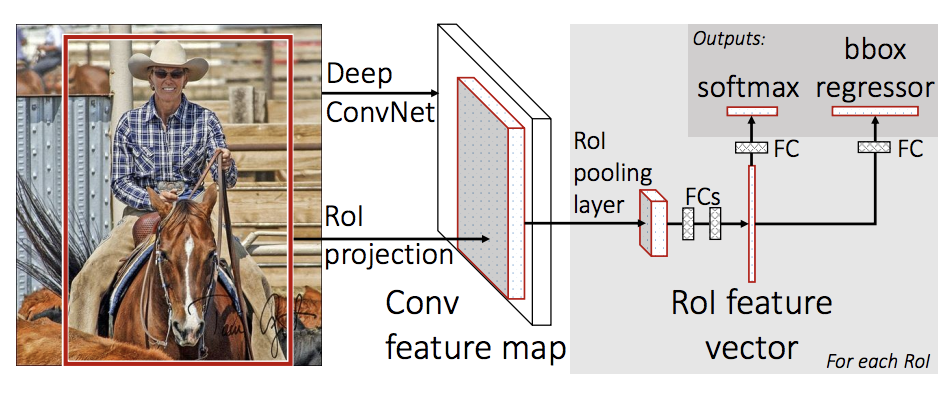
 
-----

Mask R-CNN은 각 인스턴스에 대한 분할 마스크 예측하는 추가 분기(레이어)를 Faster R-CNN에 추가한 모델

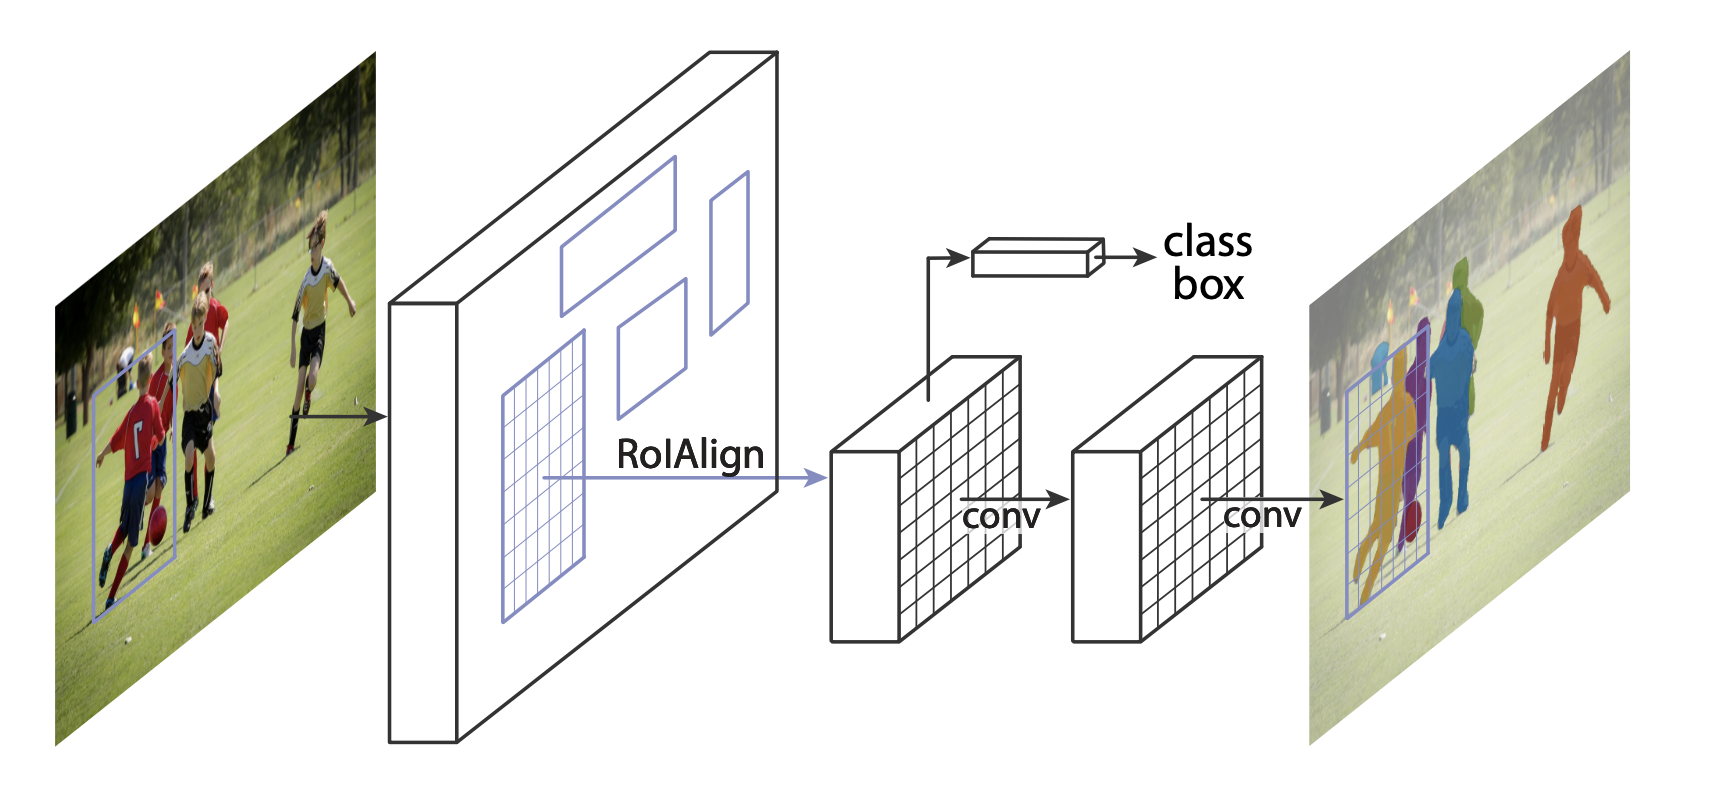


-----

Torchvision 모델주(model zoo, 역자주:미리 학습된 모델들을 모아 놓은 공간)에서 사용 가능한 모델들 중 하나를 이용해 모델을 수정하려면 보통 두가지 상황이 있습니다. 첫 번째 방법은 미리 학습된 모델에서 시작해서 마지막 레이어 수준만 미세 조정하는 것입니다. 다른 하나는 모델의 백본을 다른 백본으로 교체하는 것

### 미리 학습된 모델로부터 미세 조정

In [2]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# COCO로 미리 학습된 모델 읽기
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# 분류기를 새로운 것으로 교체하는데, num_classes는 사용자가 정의합니다
num_classes = 2  # 1 클래스(사람) + 배경
# 분류기에서 사용할 입력 특징의 차원 정보를 얻습니다
in_features = model.roi_heads.box_predictor.cls_score.in_features
# 미리 학습된 모델의 머리 부분을 새로운 것으로 교체합니다
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

### 다른 백복을 추가하도록 모델을 수정 

 

In [4]:
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

# 분류 목적으로 미리 학습된 모델을 로드하고 특징들만을 리턴
backbone = torchvision.models.mobilenet_v2(pretrained= True).features
# Faster RCNN은 백본의 출력 채널 수를 알아야 합니다.
# mobilenetV2의 경우 1280이므로 여기에 추가해야 합니다.
backbone.out_channels = 1280

# RPN(Region Proposal Network)이 5개의 서로 다른 크기와 3개의 다른 측면 비율(Aspect ratio)을 가진
# 5 x 3개의 앵커를 공간 위치마다 생성하도록 합니다.
# 각 특징 맵이 잠재적으로 다른 사이즈와 측면 비율을 가질 수 있기 때문에 Tuple[Tuple[int]] 타입을 가지도록 합니다.

anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
                                   aspect_ratios=((0.5, 1.0, 2.0),))


# 관심 영역의 자르기 및 재할당 후 자르기 크기를 수행하는 데 사용할 피쳐 맵을 정의합니다.
# 만약 백본이 텐서를 리턴할때, featmap_names 는 [0] 이 될 것이라고 예상합니다.
# 일반적으로 백본은 OrderedDict[Tensor] 타입을 리턴해야 합니다.
# 그리고 특징맵에서 사용할 featmap_names 값을 정할 수 있습니다.
roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'],
                                                output_size=7,
                                                sampling_ratio=2)

# 조각들을 Faster RCNN 모델로 합칩니다.
model = FasterRCNN(backbone,
                   num_classes=2,
                   rpn_anchor_generator=anchor_generator,
                   box_roi_pool=roi_pooler)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /Users/wonminjae/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


  0%|          | 0.00/13.6M [00:00<?, ?B/s]

### PennFudan 데이터셋을 위한 인스턴스 분할 모델



In [5]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor


def get_model_instance_segmentation(num_classes):
    # COCO 에서 미리 학습된 인스턴스 분할 모델을 읽어옵니다
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # 분류를 위한 입력 특징 차원을 얻습니다
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # 미리 학습된 헤더를 새로운 것으로 바꿉니다
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # 마스크 분류기를 위한 입력 특징들의 차원을 얻습니다
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # 마스크 예측기를 새로운 것으로 바꿉니다
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model